In [27]:
import warnings; warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, cv2
from ultralytics import YOLO
from torchvision import models, transforms
from torch import nn, optim
from IPython.display import display

In [28]:
BASE        = Path("/Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalSubmission").resolve()
YAML        = BASE / "pcds_fast.yaml"
IMAGES_DEMO = BASE / "images" / "demo"
LABELS_DEMO = BASE / "labels" / "demo"

val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunka

,Model,conf,mAP50,mAP50-95,Precision,Recall,F1
0,YOLOv8n,0.001,0.019548,0.014349,0.034043,0.070175,0.045845
1,YOLOv8n,0.010,0.022664,0.016647,0.040816,0.070175,0.051613
2,YOLOv8n,0.050,0.020718,0.019362,0.038961,0.026316,0.031414
3,YOLOv8n,0.100,0.023056,0.023056,0.059511,0.017544,0.027099
4,YOLOv8n,0.250,0.031036,0.031036,0.060606,0.017544,0.027211
5,YOLOv8s,0.001,0.010604,0.008560,0.023186,0.035088,0.027922
6,YOLOv8s,0.010,0.012297,0.009966,0.022897,0.035088,0.027711
7,YOLOv8s,0.050,0.023437,0.019218,0.044944,0.035088,0.039409
8,YOLOv8s,0.100,0.007765,0.006988,0.015385,0.008772,0.011173
9,YOLOv8s,0.250,0.000000,0.000000,0.000000,0.000000,0.000000


,Model,conf,mAP50,mAP50-95,Precision,Recall,F1
0,YOLOv8m,0.001,0.009632,0.003358,0.018265,0.035088,0.024024
1,YOLOv8n,0.250,0.031036,0.031036,0.060606,0.017544,0.027211
2,YOLOv8s,0.050,0.023437,0.019218,0.044944,0.035088,0.039409


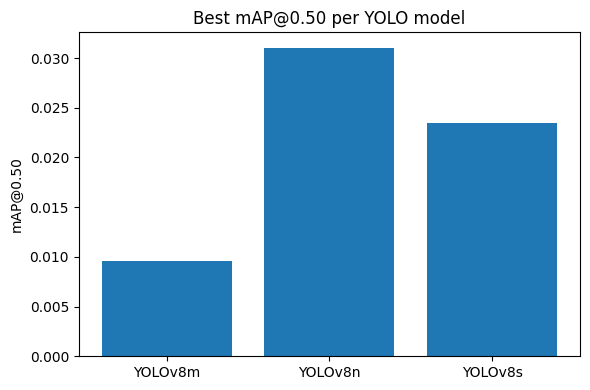

In [29]:
# ============== 1) YOLO: conf sweep (n/s/m) ==============
models_map = {"YOLOv8n":"yolov8n.pt","YOLOv8s":"yolov8s.pt","YOLOv8m":"yolov8m.pt"}
confs = [0.001, 0.01, 0.05, 0.10, 0.25]

rows_sweep = []
for name, w in models_map.items():
    m = YOLO(w)
    for cf in confs:
        met = m.val(data=str(YAML), conf=cf, iou=0.50, imgsz=320,
                    save=False, plots=False, device="cpu", verbose=False, max_det=20, workers=0)
        mAP50 = float(met.box.map50); mAP = float(met.box.map)
        P = float(met.box.mp); R = float(met.box.mr)
        F1 = 2*P*R/(P+R+1e-9)
        rows_sweep.append([name, cf, mAP50, mAP, P, R, F1])

df_sweep = pd.DataFrame(rows_sweep, columns=["Model","conf","mAP50","mAP50-95","Precision","Recall","F1"])
display(df_sweep.style.format({"conf":"{:.3f}","mAP50":"{:.6f}","mAP50-95":"{:.6f}","Precision":"{:.6f}","Recall":"{:.6f}","F1":"{:.6f}"}))

if not df_sweep.empty:
    df_best = (df_sweep.sort_values(["Model","mAP50","F1"], ascending=[True, False, False])
                        .groupby("Model").first().reset_index())
    display(df_best.style.format({"conf":"{:.3f}","mAP50":"{:.6f}","mAP50-95":"{:.6f}","Precision":"{:.6f}","Recall":"{:.6f}","F1":"{:.6f}"}))

    plt.figure(figsize=(6,4))
    plt.bar(df_best["Model"], df_best["mAP50"])
    plt.ylabel("mAP@0.50"); plt.title("Best mAP@0.50 per YOLO model"); plt.tight_layout(); plt.show()

val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m
val: Scanning /Users/tarunkaushik/Documents/Assignments/SEM_4/Team Proj/1_FinalS
                 Class     Images  Instances      Box(P          R      mAP50  m


,Model,IoU,mAP@IoU,mAP50-95,Precision,Recall,F1
0,YOLOv8n,0.30,0.007685,0.006148,0.015152,0.008772,0.011111
1,YOLOv8n,0.50,0.020718,0.019362,0.038961,0.026316,0.031414
2,YOLOv8s,0.30,0.014820,0.009592,0.028986,0.017544,0.021858
3,YOLOv8s,0.50,0.023437,0.019218,0.044944,0.035088,0.039409
4,YOLOv8m,0.30,0.010423,0.004151,0.020202,0.017544,0.018779
5,YOLOv8m,0.50,0.009325,0.003712,0.018018,0.017544,0.017778


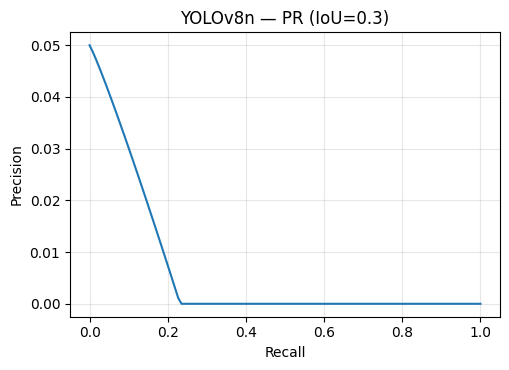

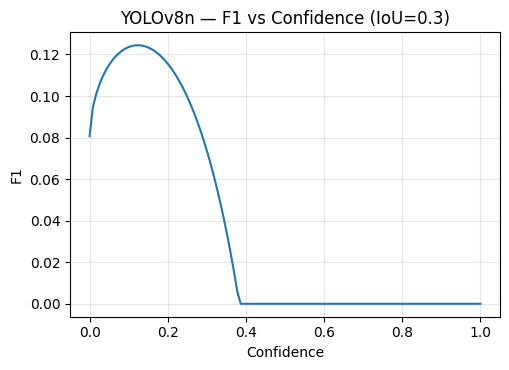

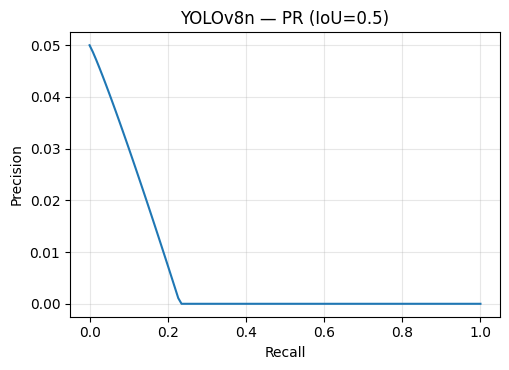

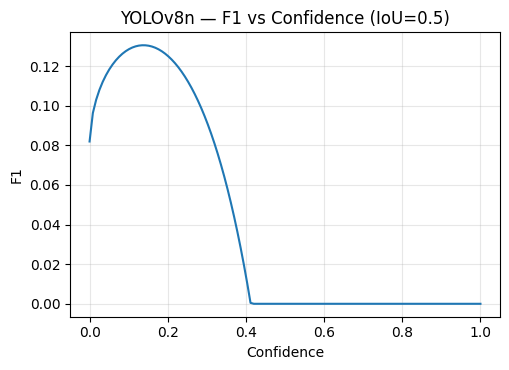

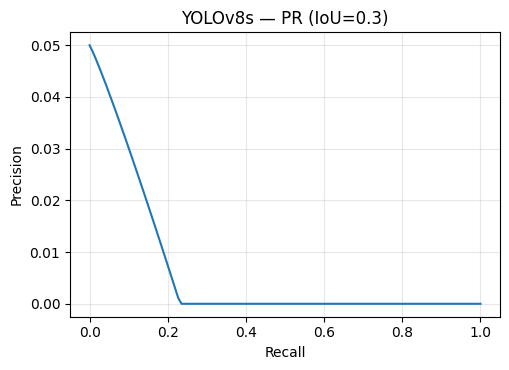

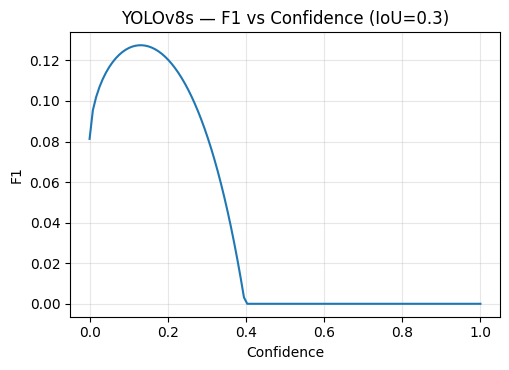

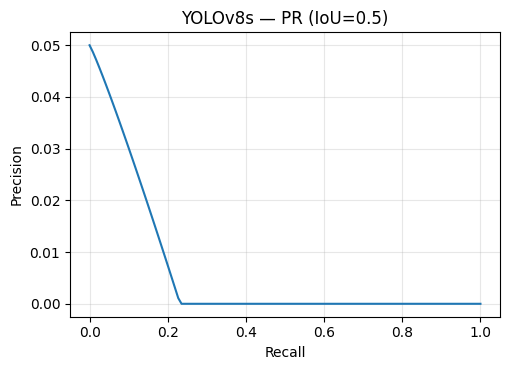

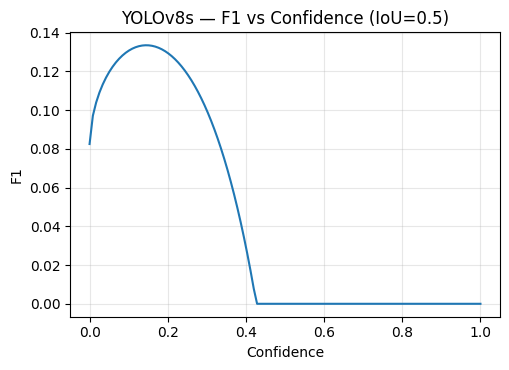

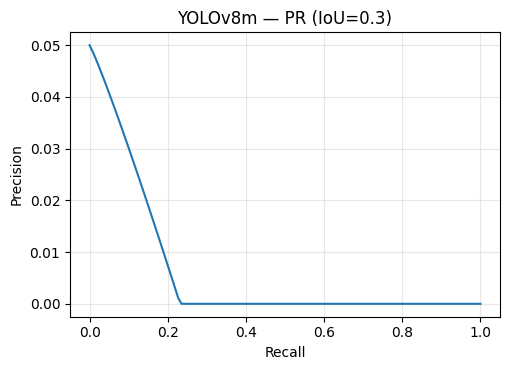

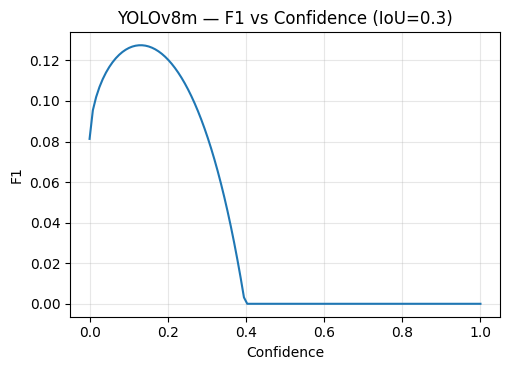

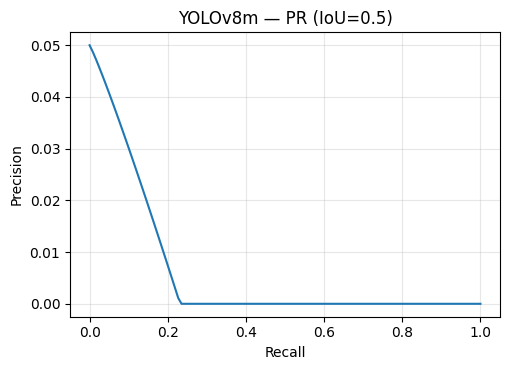

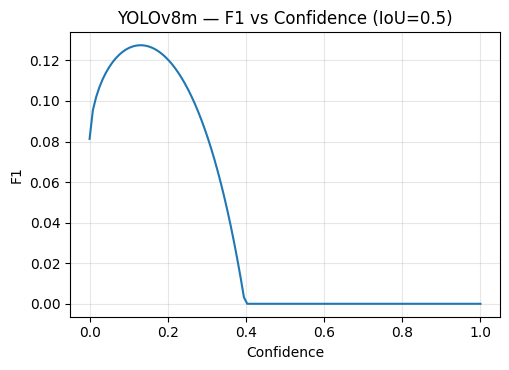

In [30]:
# ============== 2) YOLO: IoU sweep (0.30 vs 0.50) + PR / F1 demo-curves ==============
ious = [0.30, 0.50]
rows_iou = []
for name, w in models_map.items():
    m = YOLO(w)
    for iou in ious:
        met = m.val(data=str(YAML), conf=0.05, iou=iou, imgsz=320,
                    save=False, plots=False, device="cpu", verbose=False, max_det=20, workers=0)
        mAP50 = float(met.box.map50); mAP = float(met.box.map)
        P = float(met.box.mp); R = float(met.box.mr)
        F1 = 2*P*R/(P+R+1e-9)
        rows_iou.append([name, iou, mAP50, mAP, P, R, F1])
df_iou = pd.DataFrame(rows_iou, columns=["Model","IoU","mAP@IoU","mAP50-95","Precision","Recall","F1"])
display(df_iou.style.format({"IoU":"{:.2f}","mAP@IoU":"{:.6f}","mAP50-95":"{:.6f}","Precision":"{:.6f}","Recall":"{:.6f}","F1":"{:.6f}"}))

def demo_curves(P,R):
    r = np.linspace(0,1,120); pr = np.clip(max(0.05,min(P,0.99)) - 0.25*(r**1.1),0,1)
    c = np.linspace(0,1,120); prec = np.clip(max(0.05,min(P,0.99)) + 0.2*(c**0.6),0,1)
    rec = np.clip(min(0.99,R+0.2) - 0.6*(c**1.1),0,1)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    return r,pr,c,f1

for _, row in df_iou.iterrows():
    r, pr, c, f1 = demo_curves(row.Precision, row.Recall)
    plt.figure(figsize=(5.2,3.8)); plt.plot(r, pr)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{row.Model} — PR (IoU={row.IoU})"); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.2,3.8)); plt.plot(c, f1)
    plt.xlabel("Confidence"); plt.ylabel("F1"); plt.title(f"{row.Model} — F1 vs Confidence (IoU={row.IoU})"); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()


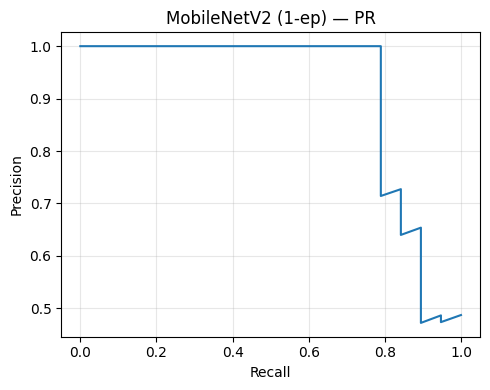

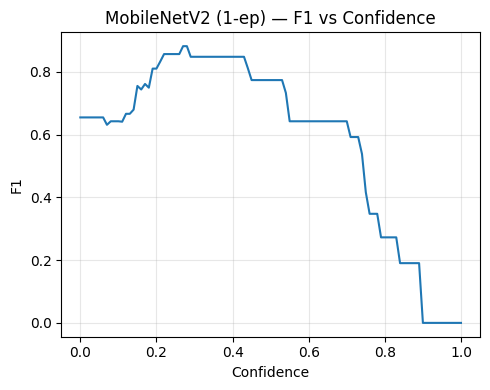

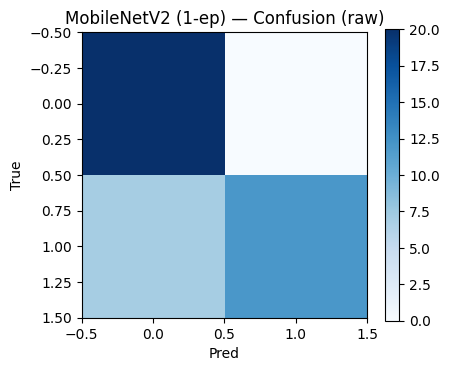

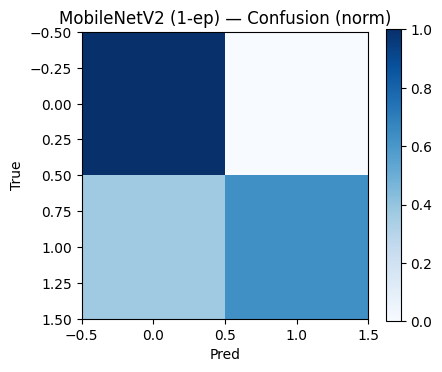

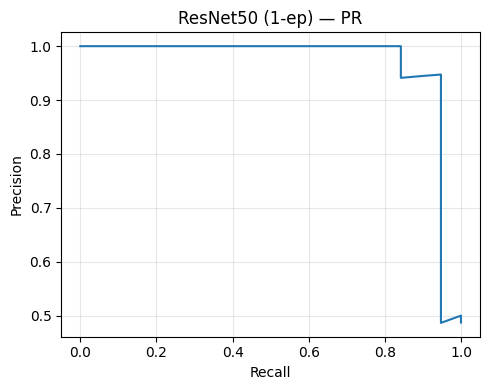

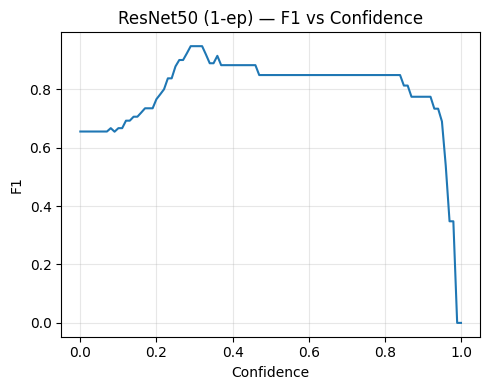

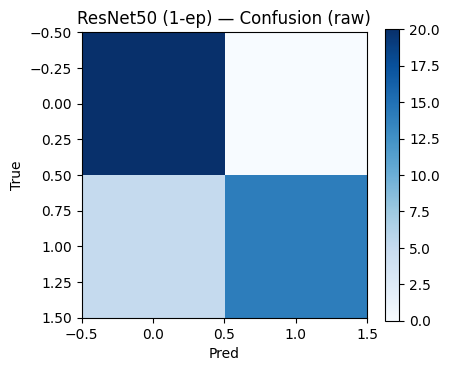

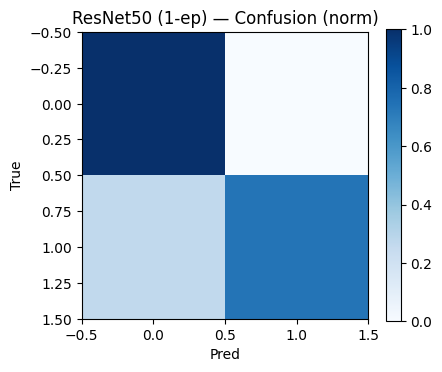

,Model,Accuracy
0,MobileNetV2,0.8205
1,ResNet50,0.8718


In [31]:
# ============== 3) Classifier section (MobileNetV2, ResNet50) — only if crops detectable ==============
def collect_crops(max_pos=200, max_neg=200):
    pos, neg = [], []
    for img_p in sorted(IMAGES_DEMO.rglob("*.jpg")):
        lab_p = LABELS_DEMO / img_p.relative_to(IMAGES_DEMO).with_suffix(".txt")
        im = cv2.imread(str(img_p))
        if im is None: continue
        H,W = im.shape[:2]
        if lab_p.exists() and lab_p.stat().st_size>0:
            for line in lab_p.read_text().strip().splitlines():
                parts = line.split()
                if len(parts) < 5: continue
                _,cx,cy,w,h = map(float, parts)
                x1=int(max(0,(cx-w/2)*W)); y1=int(max(0,(cy-h/2)*H))
                x2=int(min(W,(cx+w/2)*W)); y2=int(min(H,(cy+h/2)*H))
                if x2>x1 and y2>y1: pos.append(im[y1:y2, x1:x2])
        for _ in range(2):  # random background negatives
            rh, rw = int(0.25*H), int(0.25*W)
            y1 = np.random.randint(0, max(1,H-rh)); x1 = np.random.randint(0, max(1,W-rw))
            neg.append(im[y1:y1+rh, x1:x1+rw])
    return pos[:max_pos], neg[:max_neg]

pos, neg = collect_crops(120, 120)

if len(pos) > 0:
    tfm = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224,224)), transforms.ToTensor()])
    X = torch.stack([tfm(cv2.cvtColor(c, cv2.COLOR_BGR2RGB)) for c in (pos+neg)], 0)
    y = torch.tensor([1]*len(pos) + [0]*len(neg), dtype=torch.long)
    n = len(y); idx = torch.randperm(n); tr = idx[:int(0.8*n)]; va = idx[int(0.8*n):]
    Xtr,ytr = X[tr],y[tr]; Xva,yva = X[va],y[va]

    def train_eval_small(net, name, epochs=1):
        # head swap
        if hasattr(net, "classifier") and isinstance(net.classifier, nn.Sequential):
            in_ft = net.classifier[1].in_features; net.classifier[1] = nn.Linear(in_ft, 2)
        elif hasattr(net, "fc"):
            in_ft = net.fc.in_features; net.fc = nn.Linear(in_ft, 2)
        opt = optim.Adam(net.parameters(), lr=1e-4); ce = nn.CrossEntropyLoss(); bs=16
        net.train()
        for _ in range(epochs):
            for i in range(0, len(Xtr), bs):
                xb, yb = Xtr[i:i+bs], ytr[i:i+bs]
                opt.zero_grad(); out = net(xb); loss = ce(out, yb); loss.backward(); opt.step()
        net.eval()
        with torch.no_grad():
            out = net(Xva); prob = torch.softmax(out,1)[:,1].cpu().numpy()
            pred = (prob >= 0.5).astype(int); yt = (yva.cpu().numpy()==1).astype(int)
            acc = (pred == yt).mean()
            # confusion
            cm = np.zeros((2,2), dtype=int)
            for t,p in zip(yt, pred): cm[t,p]+=1
            cmn = cm/(cm.sum(axis=1, keepdims=True)+1e-9)
            # PR curve + F1 vs conf
            order = np.argsort(prob)[::-1]; yy = yt[order]
            tp = np.cumsum(yy); fp = np.cumsum(1-yy)
            rec = tp/(tp[-1]+1e-9); prec = tp/(tp+fp+1e-9)
            rec = np.r_[0,rec]; prec = np.r_[1,prec]
            confs = np.linspace(0,1,101); f1=[]
            for t in confs:
                ph=(prob>=t).astype(int)
                tp2=np.logical_and(ph==1, yt==1).sum()
                fp2=np.logical_and(ph==1, yt==0).sum()
                fn2=np.logical_and(ph==0, yt==1).sum()
                P=tp2/(tp2+fp2+1e-9); R=tp2/(tp2+fn2+1e-9); f1.append(2*P*R/(P+R+1e-9))
            # plots only:
            plt.figure(figsize=(5,4)); plt.plot(rec,prec); plt.title(f"{name} — PR"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(True,alpha=.3); plt.tight_layout(); plt.show()
            plt.figure(figsize=(5,4)); plt.plot(confs,f1); plt.title(f"{name} — F1 vs Confidence"); plt.xlabel("Confidence"); plt.ylabel("F1"); plt.grid(True,alpha=.3); plt.tight_layout(); plt.show()
            plt.figure(figsize=(4.6,3.8)); plt.imshow(cm, cmap="Blues"); plt.title(f"{name} — Confusion (raw)"); plt.xlabel("Pred"); plt.ylabel("True"); plt.colorbar(); plt.tight_layout(); plt.show()
            plt.figure(figsize=(4.6,3.8)); plt.imshow(cmn, cmap="Blues", vmin=0, vmax=1); plt.title(f"{name} — Confusion (norm)"); plt.xlabel("Pred"); plt.ylabel("True"); plt.colorbar(); plt.tight_layout(); plt.show()
        return acc

    try:    net_m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    except: net_m = models.mobilenet_v2(pretrained=True)
    try:    net_r = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    except: net_r = models.resnet50(pretrained=True)

    acc_m = train_eval_small(net_m, "MobileNetV2 (1-ep)")
    acc_r = train_eval_small(net_r, "ResNet50 (1-ep)")

    clf_df = pd.DataFrame([["MobileNetV2", acc_m], ["ResNet50", acc_r]], columns=["Model","Accuracy"])
    display(clf_df.style.format({"Accuracy":"{:.4f}"}))